# KNN - MULTICLASS CLASSIFICATION

In [155]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [156]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

## Preprocessing delle variabili

#### Eliminazione outliers

In [157]:
copy_train = copy_train[copy_train["outlier_no_type"] != True]
copy_test = copy_test[copy_test["outlier_no_type"] != True]

#### Eliminazione variabili inutilizzabili

In [158]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

In [159]:
copy_test.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

##### Mapping variabile target

In [160]:
y = np.array(copy_train['titleType'])  # Il target originale

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(copy_train['titleType'].unique())}

#aggiungo una nuova colonna
copy_train['titleType_encoded'] = copy_train['titleType'].map(y_map)
copy_test['titleType_encoded'] = copy_test['titleType'].map(y_map)

y_map  # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'tvMiniSeries': 3,
 'short': 4,
 'tvMovie': 5,
 'tvSpecial': 6,
 'video': 7}

#### Conversione CanHaveEpisodes in binaria 0/1

In [161]:
copy_train["canHaveEpisodes"] = copy_train["canHaveEpisodes"].astype(int)
copy_test["canHaveEpisodes"] = copy_test["canHaveEpisodes"].astype(int)

#### Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [162]:
copy_train = copy_train.drop(["originalTitle", "runtimeMinutes"], axis=1)
copy_test = copy_test.drop(["originalTitle", "runtimeMinutes"], axis=1)

In [163]:
copy_train = copy_train.drop(["titleType"], axis=1)
copy_test = copy_test.drop(["titleType"], axis=1)

#### Rimuoviamo endYear 

In [164]:
copy_train = copy_train.drop(["endYear"], axis=1)
copy_test = copy_test.drop(["endYear"], axis=1)

### Filtra il dataset sulle classi meno rappresentate --> ('videoGame': 1),'tvMiniSeries': 5, 'tvSpecial': 8, 'tvShort': 9

In [165]:
# copy_train = copy_train[~copy_train['titleType_encoded'].isin([1, 5, 8, 9])]
# copy_test = copy_test[~copy_test['titleType_encoded'].isin([1, 5, 8, 9])]

#### Encoding di titletype per multiclass classification task

In [166]:
# Extract target (y)
y_train = copy_train["titleType_encoded"].values  # Convert directly to NumPy
y_test = copy_test["titleType_encoded"].values  # Convert directly to NumPy

#### Selezione variabili

In [167]:
# VAR USATE PER PRIMO TENTATIVO CLASSIFICATION (vedere file KNN su drive)
# selected_var_tr = copy_train[['startYear', 'awardWins', 'numVotes', 'totalImages',
#        'totalCredits', "totalVideos", 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
#        'numRegions', 'userReviewsTotal', 
#        "fill_runtimeMinutes", 
#        "rating", 
#        'is_from_Oceania', 'is_from_Europe','is_from_Asia', 'is_from_Africa', 'is_from_North America'
#        ]].values



# VAR USATE PER CLASSIFICATION CON LE NUOVE MODIFICHE SUL DF
selected_var_tr = copy_train[[
       'startYear', # >> in teoria non dovrebbe essere log transformed da report
       'numVotes', 'totalNominations', 'totalMedia', 
       'totalCredits', 'criticReviewsTotal', 'canHaveEpisodes', 
       # 'isAdult', >>> tolta perchè non esiste più
       'numRegions', 'userReviewsTotal', 
       #"fill_runtimeMinutes",
       #'fill_runtimeMinutes_Bruno',
       'runtimeMinutes_notitletype',
       "rating", #>> perchè normalizzata?
       'countryOfOrigin_NA', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU',
       'countryOfOrigin_OC', 'countryOfOrigin_SA', 'countryOfOrigin_UNK',
       'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation'
       ]].values


# VAR USATE PER PRIMO TENTATIVO CLASSIFICATION (vedere file KNN su drive)
# selected_var_ts = copy_test[['startYear', 'awardWins', 'numVotes', 'totalImages',
#        'totalCredits', "totalVideos", 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
#        'numRegions', 'userReviewsTotal',
#        "fill_runtimeMinutes", 
#        "rating", 
#        'is_from_Oceania', 'is_from_Europe', 'is_from_Asia', 'is_from_Africa', 'is_from_North America'
#        ]].values


# VAR USATE PER CLASSIFICATION CON LE NUOVE MODIFICHE SUL DF
selected_var_ts = copy_test[[
       'startYear', # >> in teoria non dovrebbe essere log transformed da report
       'numVotes', 'totalNominations', 'totalMedia', 
       'totalCredits', 'criticReviewsTotal', 'canHaveEpisodes', 
       # 'isAdult', >>> tolta perchè non esiste più
       'numRegions', 'userReviewsTotal', 
       #"fill_runtimeMinutes",
       #'fill_runtimeMinutes_Bruno',
       'runtimeMinutes_notitletype',
       "rating", #>> perchè normalizzata??
       'countryOfOrigin_NA', 'countryOfOrigin_freq_enc',
       'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU',
       'countryOfOrigin_OC', 'countryOfOrigin_SA', 'countryOfOrigin_UNK',
       'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation'
       ]].values

#### Splitting train-validation

In [168]:
X_train2, X_val, y_train2, y_val = train_test_split(
     selected_var_tr, y_train, test_size=0.2, random_state=32
)

# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

In [169]:
print(X_train2.shape, X_val.shape, selected_var_tr.shape, selected_var_ts.shape)

(12626, 47) (3157, 47) (15783, 47) (5246, 47)


#### Normalizzazione

In [170]:
selected_var_tr_log = np.log1p(selected_var_tr)
X_train2_numeric_log = np.log1p(X_train2)
X_val_numeric_log = np.log1p(X_val)

X_test_numeric_log = np.log1p(selected_var_ts)

In [171]:
scaler = StandardScaler()

# # Fittiamo SOLO su train e trasformiamo tutto
X_train_standardsc = scaler.fit_transform(selected_var_tr_log)
X_train2_standardsc = scaler.fit_transform(X_train2_numeric_log)
X_val_standardsc = scaler.fit_transform(X_val_numeric_log)

X_test_standardsc = scaler.transform(X_test_numeric_log)


In [172]:
minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train_minmax = minmax.fit_transform(selected_var_tr_log)
X_train2_minmax = minmax.fit_transform(X_train2_numeric_log)
X_val_minmax = minmax.fit_transform(X_val_numeric_log)

X_test_minmax = minmax.transform(X_test_numeric_log)

## KNN

### RandomizedSearch per trovare gli iperparametri

### FUNZIONE VECCHIA

In [173]:
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# from scipy.stats import randint

# def optimize_knn(X_train, y_train, n_iter=100, cv=5, verbose=1):
#     # Calculate reasonable k range based on square root rule
#     # sqrt(N) is a common rule of thumb for KNN
#     sqrt_n = int(np.sqrt(X_train.shape[0]))
    
#     # Define parameter space with more focused ranges
#     param_distributions = {
#         "n_neighbors": np.arange(1, sqrt_n+1),  # Focus around sqrt(N)
#         "weights": ["uniform", "distance"],
#         "metric": ["euclidean", "cityblock"]
#     }
    
#     # Create the RandomizedSearchCV object with improved settings
#     random_search = RandomizedSearchCV(
#         KNeighborsClassifier(),
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),  # Stratified k-fold is usually sufficient
#         n_jobs=-1,
#         refit=True,
#         random_state=42,
#         verbose=verbose,
#         scoring='accuracy',  # Specify your preferred metric
#         return_train_score=True  # Good for checking overfitting
#     )
    
#     # Fit the model
#     random_search.fit(X_train2_standardsc, y_train)
    
#         # Show top 5 models to see parameter sensitivity
#     results = random_search.cv_results_
#     sorted_idx = np.argsort(results['rank_test_score'])
#     print("\nTop 5 configurations:")
#     for i in range(5):
#         idx = sorted_idx[i]
#         print(f"Rank {i+1}: {results['params'][idx]}")
#         print(f"   Test score: {results['mean_test_score'][idx]:.4f}")
#         print(f"   Train score: {results['mean_train_score'][idx]:.4f}")

#     return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

### FUNZIONE NUOVA

In [174]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
    # Calcolo range k
    sqrt_n = int(np.sqrt(X_train.shape[0]))
    
    param_distributions = {
        "n_neighbors": np.arange(1, sqrt_n + 1),
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "cityblock"]
    }
    
    random_search = RandomizedSearchCV(
        KNeighborsClassifier(),
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        n_jobs=-1,
        refit=True,
        random_state=42,
        verbose=verbose,
        scoring='accuracy',
        return_train_score=True
    )

    # Fit solo sul training set
    random_search.fit(X_train, y_train)
#
    # Valutazione su validation set
    best_model = random_search.best_estimator_
    y_val_pred = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Mostra le top 5 configurazioni (sulla cross-validation)
    results = random_search.cv_results_
    sorted_idx = np.argsort(results['rank_test_score'])
    print("\nTop 5 configurations (CV scores):")
    for i in range(5):
        idx = sorted_idx[i]
        print(f"Rank {i+1}: {results['params'][idx]}")
        print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
        print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

    print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

    return best_model, random_search.best_params_, val_accuracy

### CELLA DA RUNNARE DOPO AVER CONTROLLATO NUOVA CONFIGURAZIONE PARAMETRI

In [175]:
# best_knn, best_params, best_score = optimize_knn(X_train2_standardsc, y_train2)

best_knn, best_params, val_score = optimize_knn_with_external_validation(
    X_train2_standardsc, y_train2, X_val_standardsc, y_val)


# # Create a new classifier with the optimized parameters
clf = KNeighborsClassifier(**best_params)
clf.fit(X_train2_standardsc, y_train2)

y_pred = clf.predict(X_val_standardsc)

Fitting 5 folds for each of 100 candidates, totalling 500 fits



Top 5 configurations (CV scores):
Rank 1: {'weights': 'distance', 'n_neighbors': 12, 'metric': 'cityblock'}
   CV Test score: 0.8342
   CV Train score: 1.0000
Rank 2: {'weights': 'distance', 'n_neighbors': 11, 'metric': 'cityblock'}
   CV Test score: 0.8322
   CV Train score: 1.0000
Rank 3: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'cityblock'}
   CV Test score: 0.8292
   CV Train score: 1.0000
Rank 4: {'weights': 'distance', 'n_neighbors': 19, 'metric': 'cityblock'}
   CV Test score: 0.8291
   CV Train score: 1.0000
Rank 5: {'weights': 'distance', 'n_neighbors': 26, 'metric': 'cityblock'}
   CV Test score: 0.8277
   CV Train score: 1.0000

Validation Accuracy of Best Model: 0.8429


### CELLA DA RUNNARE SE SI SANNO GIA' I PARAMETRI

In [204]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 11, metric = 'cityblock')
clf.fit(X_train2_standardsc, y_train2)

y_pred = clf.predict(X_val_standardsc)

In [192]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3157
3157


### Results of the prediction on the validation set

In [205]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}


In [206]:
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}
index_to_class = {v: k for k, v in class_mapping.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print(f"Validation accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=target_names))

Validation accuracy: 0.8333861260690529

Classification Report:
              precision    recall  f1-score   support

   tvEpisode       0.82      0.94      0.88       952
       movie       0.83      0.88      0.86      1072
    tvSeries       0.91      0.86      0.89       268
tvMiniSeries       0.67      0.08      0.14        26
       short       0.94      0.93      0.93       470
     tvMovie       0.48      0.23      0.31       179
   tvSpecial       0.48      0.32      0.38        31
       video       0.70      0.45      0.54       159

    accuracy                           0.83      3157
   macro avg       0.73      0.59      0.62      3157
weighted avg       0.82      0.83      0.82      3157



Performance sul Training set:
Accuracy: 0.8482
F1 Score: 0.8337

Performance sul Validation set:
Accuracy: 0.8385
F1 Score: 0.8231


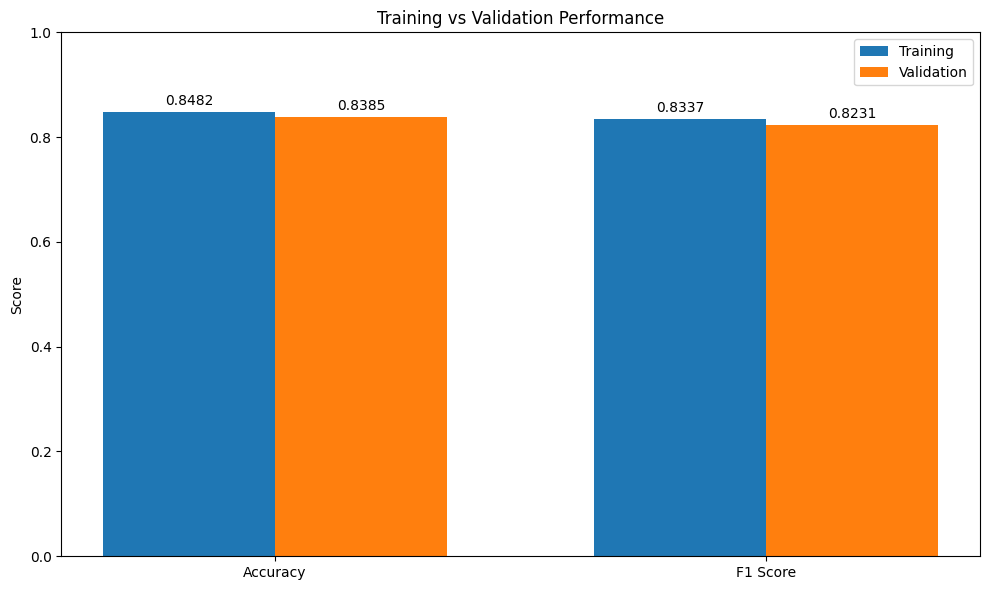

In [195]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_standardsc)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_standardsc)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

### Distribuzione classi nel training set
- da notare come le classi con support più basso sono ovviamente quelle con performance peggiori 

In [181]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3738
1    4370
2    1069
3     160
4    1912
5     665
6     127
7     585
Name: count, dtype: int64


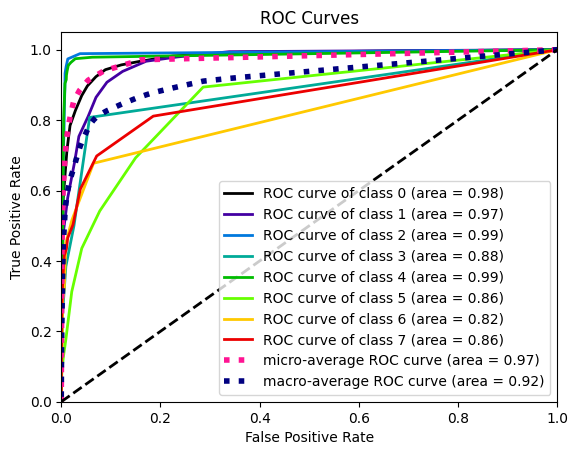

In [196]:
y_val_pred_proba = clf.predict_proba(X_val_standardsc)
plot_roc(y_val, y_val_pred_proba)
plt.show()

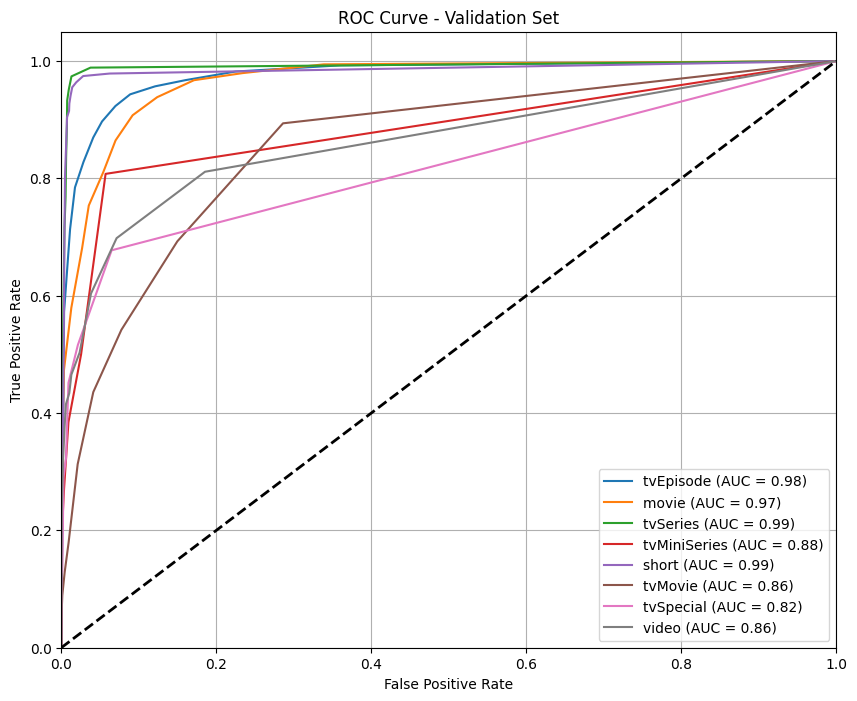

In [197]:

# Your class mapping
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}

# Invert mapping
index_to_class = {v: k for k, v in class_mapping.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

# Predict probabilities
y_val_pred_proba = clf.predict_proba(X_val_standardsc)

# If y_val is label-encoded, binarize it for ROC
y_val_bin = label_binarize(y_val, classes=list(range(len(class_mapping))))

# Plot ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_val_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc='lower right')
plt.grid()
plt.show()


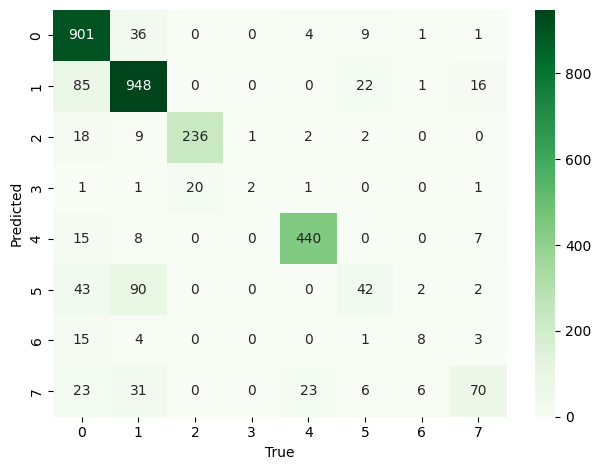

In [198]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

### Proper testing on the test set (once getting the right hyperparameters)

In [199]:
clf = KNeighborsClassifier(weights = 'uniform', n_neighbors= 12, metric = 'cityblock')
clf.fit(X_train_standardsc, y_train)

y_pred = clf.predict(X_test_standardsc)

Performance sul Training set:
Accuracy: 0.8536
F1 Score: 0.8396

Performance sul Test set:
Accuracy: 0.8385
F1 Score: 0.8231


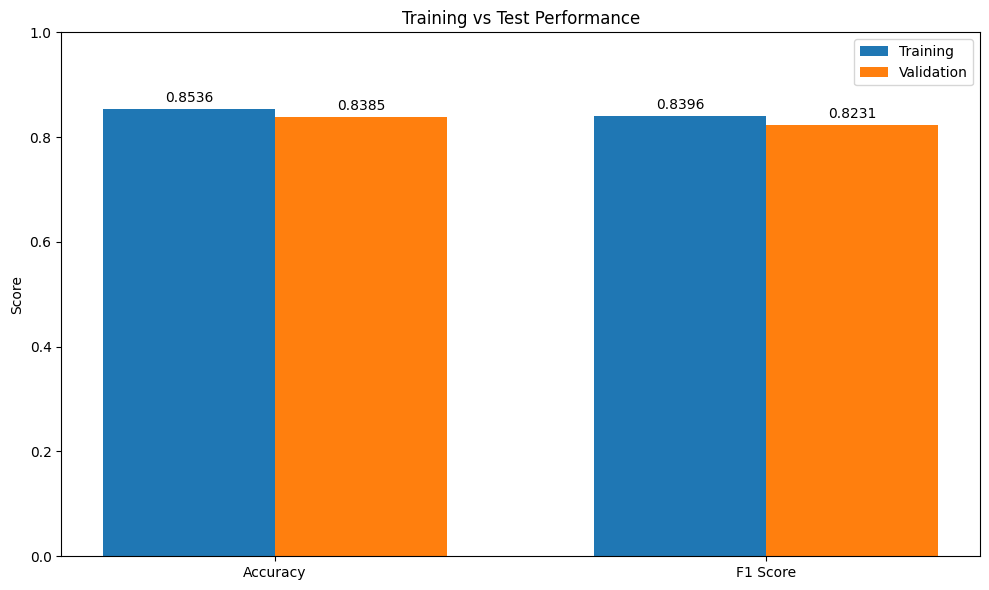

In [200]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_standardsc)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_test = clf.predict(X_test_standardsc)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Test set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Test Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [201]:
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}
index_to_class = {v: k for k, v in class_mapping.items()}
target_names = [index_to_class[i] for i in range(len(index_to_class))]

print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

Test accuracy: 0.8360655737704918

Classification Report:
              precision    recall  f1-score   support

   tvEpisode       0.83      0.95      0.88      1596
       movie       0.85      0.89      0.87      1848
    tvSeries       0.88      0.86      0.87       437
tvMiniSeries       0.40      0.03      0.05        68
       short       0.93      0.92      0.93       728
     tvMovie       0.47      0.22      0.29       288
   tvSpecial       0.48      0.38      0.43        42
       video       0.64      0.45      0.53       239

    accuracy                           0.84      5246
   macro avg       0.68      0.59      0.61      5246
weighted avg       0.82      0.84      0.82      5246



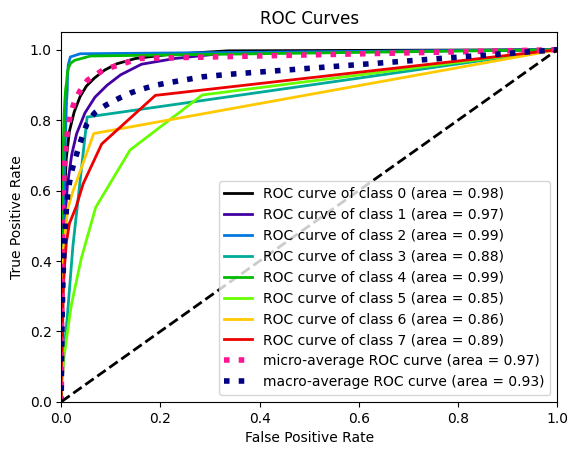

In [202]:
y_test_pred_proba = clf.predict_proba(X_test_standardsc)
plot_roc(y_test, y_test_pred_proba)
plt.show()

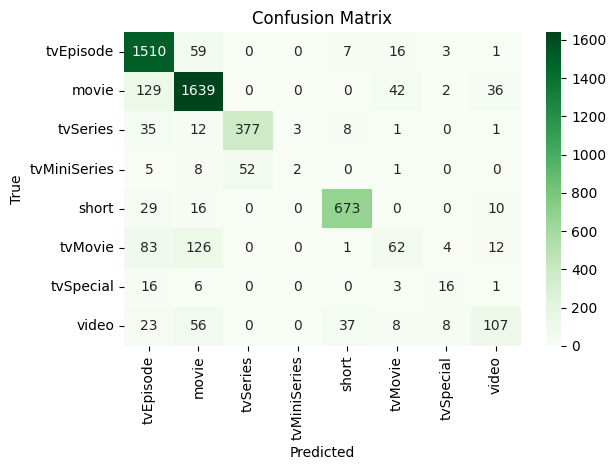

In [203]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Class mapping
class_mapping = {
    'tvEpisode': 0,
    'movie': 1,
    'tvSeries': 2,
    'tvMiniSeries': 3,
    'short': 4,
    'tvMovie': 5,
    'tvSpecial': 6,
    'video': 7
}

# Invert mapping
index_to_class = {v: k for k, v in class_mapping.items()}

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get sorted unique class indices from y_test (or y_pred)
classes_unique = np.unique(np.concatenate([y_test, y_pred]))

# Convert indices to class names
class_names = [index_to_class[i] for i in classes_unique]

# Plot heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


### Compare the results with a dummy classifier

In [190]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_standardsc, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_standardsc)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.3522683949675944
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1596
           1       0.35      1.00      0.52      1848
           2       0.00      0.00      0.00       437
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00       728
           5       0.00      0.00      0.00       288
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00       239

    accuracy                           0.35      5246
   macro avg       0.04      0.12      0.07      5246
weighted avg       0.12      0.35      0.18      5246



C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
